<a href="https://colab.research.google.com/github/NikuDubenco/DS-Unit-2-Classification-2/blob/master/Nicolae_Dubenco_class_imbalance_roc_auc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Leading club review

In [1]:
!pip install category_encoders

     |████████████████████████████████| 92kB 4.6MB/s 


In [0]:
history_location = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Classification-2/master/data/lending-club-subset.csv'
current_location = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Classification-2/master/data/primaryMarketNotes_browseNotes_1-RETAIL.csv'

In [0]:
import pandas as pd
pd.options.display.max_columns = 200
pd.options.display.max_rows = 200

# stratified sample, 10% of expired LC loans, grades A-D
history = pd.read_csv(history_location)
history['issue_d'] = pd.to_datetime(history['issue_d'], infer_datetime_format=True)

# current loans available for manual investing, June 17, 2019
current = pd.read_csv(current_location)

In [4]:
# calculate % of each loan repaid
history['percent_paid'] = history['total_pymnt'] / history['funded_amnt']

# see % paid for charged off vs fully paid loans
history.groupby('loan_status')['percent_paid'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,22477.0,0.546541,0.278077,0.0,0.327761,0.514006,0.742090,1.490546
Fully Paid,105857.0,1.146904,0.089759,1.0,1.083836,1.132098,1.195798,1.623628


## begin with baseline: expected value of random decisions

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import percentileofscore
import seaborn as sns
from tqdm import tnrange

In [0]:
def simulate(n=10000, grades=['A', 'B', 'C', 'D'],
            start_date='2007-07-01',
            end_date='2019-03-01'):
  
  condition = ((history['grade'].isin(grades)) &
              (history['issue_d'] >= start_date) &
              (history['issue_d'] <= end_date))
  possible = history[condition]
  
  simulations = []
  for _ in tnrange(n):
    picks = possible.sample(40).copy()
    picks['paid'] = 25 * picks['percent_paid']
    paid = picks['paid'].sum()
    simulations.append(paid)
    
  simulations = pd.Series(simulations)
  sns.distplot(simulations)
  plt.axvline(x=1000)
  percent = percentileofscore(simulations, 1000)
  plt.title(f'{percent}% of simulations did not profit. {start_date}-{end_date}, {grades}')

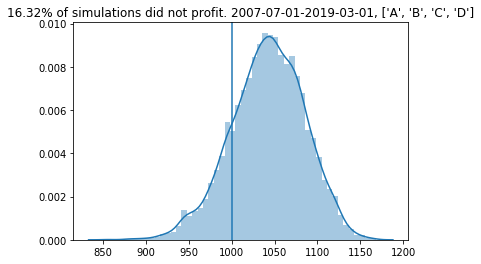

In [7]:
simulate()

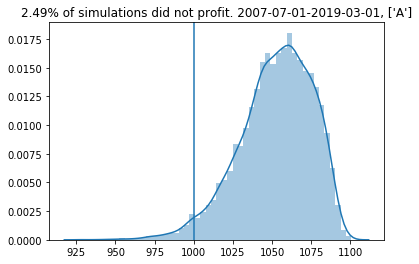

In [8]:
simulate(grades=['A'])

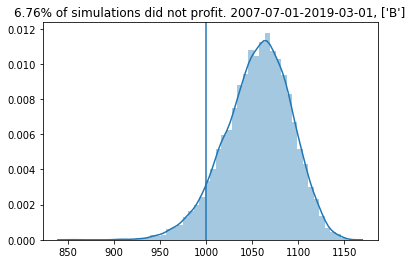

In [9]:
simulate(grades=['B'])

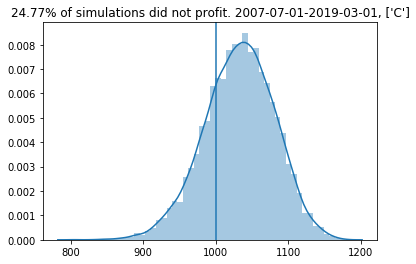

In [10]:
simulate(grades=['C'])

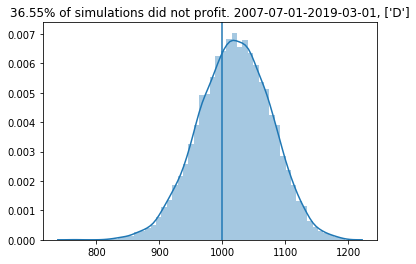

In [11]:
simulate(grades=['D'])

### Remove features to avoid leakage

In [0]:
# transform earliest_cr_line to an integer:
# how many days the earliest credit line was open, before the loan was issued.
# for current loans available for manual investing, assume the loan will be issued today.

history['earliest_cr_line'] = pd.to_datetime(history['earliest_cr_line'], infer_datetime_format=True)
history['earliest_cr_line'] = history['issue_d'] - history['earliest_cr_line']
history['earliest_cr_line'] = history['earliest_cr_line'].dt.days

current['earliest_cr_line'] = pd.to_datetime(current['earliest_cr_line'], infer_datetime_format=True)
current['earliest_cr_line'] = pd.Timestamp.today() - current['earliest_cr_line']
current['earliest_cr_line'] = current['earliest_cr_line'].dt.days

In [13]:
# use python sets to compare the historical columns & current columns

common_columns = set(history.columns) & set(current.columns)
common_columns

{'acc_now_delinq',
 'acc_open_past_24mths',
 'addr_state',
 'all_util',
 'annual_inc',
 'annual_inc_joint',
 'application_type',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'collections_12_mths_ex_med',
 'delinq_2yrs',
 'delinq_amnt',
 'desc',
 'dti',
 'dti_joint',
 'earliest_cr_line',
 'emp_length',
 'emp_title',
 'fico_range_high',
 'fico_range_low',
 'funded_amnt',
 'grade',
 'home_ownership',
 'id',
 'il_util',
 'initial_list_status',
 'inq_fi',
 'inq_last_12m',
 'inq_last_6mths',
 'installment',
 'int_rate',
 'loan_amnt',
 'max_bal_bc',
 'member_id',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_last_delinq',
 'mths_since_last_major_derog',
 'mths_since_last_record',
 'mths_since_rcnt_il',
 'mths_since_recent_bc',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_inq',
 'mths_since_recent_revol_delinq',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_actv_rev_tl',
 'num_bc_s

In [14]:
just_history = set(history.columns) - set(current.columns)
just_history

{'collection_recovery_fee',
 'debt_settlement_flag',
 'debt_settlement_flag_date',
 'deferral_term',
 'funded_amnt_inv',
 'hardship_amount',
 'hardship_dpd',
 'hardship_end_date',
 'hardship_flag',
 'hardship_last_payment_amount',
 'hardship_length',
 'hardship_loan_status',
 'hardship_payoff_balance_amount',
 'hardship_reason',
 'hardship_start_date',
 'hardship_status',
 'hardship_type',
 'issue_d',
 'last_credit_pull_d',
 'last_fico_range_high',
 'last_fico_range_low',
 'last_pymnt_amnt',
 'last_pymnt_d',
 'loan_status',
 'next_pymnt_d',
 'orig_projected_additional_accrued_interest',
 'out_prncp',
 'out_prncp_inv',
 'payment_plan_start_date',
 'percent_paid',
 'policy_code',
 'pymnt_plan',
 'recoveries',
 'settlement_amount',
 'settlement_date',
 'settlement_percentage',
 'settlement_status',
 'settlement_term',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_int',
 'total_rec_late_fee',
 'total_rec_prncp',
 'verification_status',
 'verification_status_joint'}

In [15]:
just_current = set(current.columns) - set(history.columns)
just_current

{'accept_d',
 'credit_pull_d',
 'disbursement_method',
 'effective_int_rate',
 'exp_d',
 'exp_default_rate',
 'housing_payment',
 'ils_exp_d',
 'is_inc_v',
 'list_d',
 'msa',
 'mtg_payment',
 'review_status',
 'review_status_d',
 'service_fee_rate',
 'verified_status_joint'}

In [0]:
# train on historical data. for features, use only the common columns shared by
# the historical & current data. for the target, use 'loan_status'

features = list(common_columns)
target = 'loan_status'
X = history[features]
y = history[target]

In [19]:
# do train/validate/test 3 way split
from sklearn.model_selection import train_test_split

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=20000, stratify=y, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=20000, stratify=y_trainval, random_state=42)

print('X_train shape', X_train.shape)
print('y_train shape', y_train.shape)
print('X_val shape', X_val.shape)
print('y_val shape', y_val.shape)
print('X_test shape', X_test.shape)
print('y_test shape', y_test.shape)

X_train shape (88334, 106)
y_train shape (88334,)
X_val shape (20000, 106)
y_val shape (20000,)
X_test shape (20000, 106)
y_test shape (20000,)


## Understand why accuracy is a misleading metric when classes are imbalanced

In [20]:
# get accuracy score
y_train.value_counts(normalize=True)

Fully Paid     0.824858
Charged Off    0.175142
Name: loan_status, dtype: float64

In [21]:
import numpy as np
from sklearn.metrics import accuracy_score
majority_class = y_train.mode()[0]
y_pred = np.full_like(y_val, fill_value=majority_class)
accuracy_score(y_val, y_pred)

0.82485

In [0]:
# get confusion matrix for majority class baseline
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred):
  labels = unique_labels(y_true)
  columns = [f'Predicted {label}' for label in labels]
  index = [f'Actual {label}' for label in labels]
  table = pd.DataFrame(confusion_matrix(y_true, y_pred),
                      columns=columns, index=index)
  return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

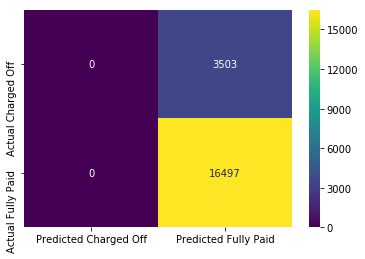

In [25]:
plot_confusion_matrix(y_val, y_pred);

In [26]:
# get precision and recall for majority class baseline
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

 Charged Off       0.00      0.00      0.00      3503
  Fully Paid       0.82      1.00      0.90     16497

    accuracy                           0.82     20000
   macro avg       0.41      0.50      0.45     20000
weighted avg       0.68      0.82      0.75     20000



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [27]:
# get ROC AUC score for majority class baseline
from sklearn.metrics import roc_auc_score

y_pred_proba = np.full_like(y_val, fill_value=1)
roc_auc_score(y_val, y_pred_proba)

0.5

In [28]:
y_pred_proba = np.full_like(y_val, fill_value=0)
roc_auc_score(y_val, y_pred_proba)

0.5

### Fit model

In [29]:
# count missing values
null_counts = X_train.isnull().sum().sort_values(ascending=False)
null_counts.reset_index()

,index,0
0,member_id,88334
1,sec_app_mths_since_last_major_derog,87855
2,sec_app_revol_util,86968
3,sec_app_open_act_il,86954
4,sec_app_fico_range_high,86954
5,sec_app_inq_last_6mths,86954
6,sec_app_num_rev_accts,86954
7,sec_app_chargeoff_within_12_mths,86954
8,revol_bal_joint,86954
9,sec_app_collections_12_mths_ex_med,86954


In [30]:
many_nulls = null_counts[:73].index
print(list(many_nulls))

['member_id', 'sec_app_mths_since_last_major_derog', 'sec_app_revol_util', 'sec_app_open_act_il', 'sec_app_fico_range_high', 'sec_app_inq_last_6mths', 'sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths', 'revol_bal_joint', 'sec_app_collections_12_mths_ex_med', 'sec_app_earliest_cr_line', 'sec_app_open_acc', 'sec_app_mort_acc', 'sec_app_fico_range_low', 'dti_joint', 'annual_inc_joint', 'desc', 'mths_since_last_record', 'mths_since_recent_bc_dlq', 'mths_since_last_major_derog', 'mths_since_recent_revol_delinq', 'il_util', 'mths_since_rcnt_il', 'total_bal_il', 'total_cu_tl', 'open_act_il', 'open_rv_24m', 'open_acc_6m', 'inq_fi', 'inq_last_12m', 'open_rv_12m', 'all_util', 'open_il_12m', 'max_bal_bc', 'open_il_24m', 'mths_since_last_delinq', 'mths_since_recent_inq', 'num_tl_120dpd_2m', 'mo_sin_old_il_acct', 'emp_title', 'emp_length', 'pct_tl_nvr_dlq', 'avg_cur_bal', 'total_rev_hi_lim', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'mo_sin_old_rev_tl_op', 'num_tl_op_past_12m', 'num_tl_3

In [33]:
%%time

def wrangle(X):
  X = X.copy()
  
  X['int_rate'] = X['int_rate'].str.strip('%').astype(float)
  X['revol_util'] = X['revol_util'].str.strip('%').astype(float)
  
  X['emp_title'] = X['emp_title'].str.lower()
  X['emp_title_treacher'] = X['emp_title'].str.contains('teacher', na=False)
  X['emp_title_manager'] = X['emp_title'].str.contains('manager', na=False)
  X['emp_title_owner'] = X['emp_title'].str.contains('owner', na=False)
  
  many_nulls = ['member_id', 'sec_app_mths_since_last_major_derog', 'sec_app_revol_util', 
                'sec_app_open_act_il', 'sec_app_chargeoff_within_12_mths', 'sec_app_mort_acc', 
                'sec_app_fico_range_high', 'revol_bal_joint', 'sec_app_collections_12_mths_ex_med', 
                'sec_app_inq_last_6mths', 'sec_app_num_rev_accts', 'sec_app_open_acc', 
                'sec_app_earliest_cr_line', 'sec_app_fico_range_low', 'annual_inc_joint', 
                'dti_joint', 'desc', 'mths_since_last_record', 'mths_since_recent_bc_dlq', 
                'mths_since_last_major_derog', 'mths_since_recent_revol_delinq', 'il_util', 
                'mths_since_rcnt_il', 'all_util', 'open_il_12m', 'total_bal_il', 'open_il_24m', 
                'inq_last_12m', 'open_rv_12m', 'max_bal_bc', 'open_act_il', 'open_rv_24m', 'inq_fi', 
                'open_acc_6m', 'total_cu_tl', 'mths_since_last_delinq', 'mths_since_recent_inq', 
                'num_tl_120dpd_2m', 'mo_sin_old_il_acct', 'emp_title', 'emp_length', 'pct_tl_nvr_dlq', 
                'avg_cur_bal', 'mo_sin_rcnt_rev_tl_op', 'num_actv_bc_tl', 'num_il_tl', 
                'mo_sin_rcnt_tl', 'total_rev_hi_lim', 'tot_cur_bal', 'num_bc_tl', 'num_tl_30dpd', 
                'num_op_rev_tl', 'mo_sin_old_rev_tl_op', 'total_il_high_credit_limit', 
                'num_rev_tl_bal_gt_0', 'num_accts_ever_120_pd', 'num_tl_90g_dpd_24m', 
                'num_tl_op_past_12m', 'num_rev_accts', 'tot_hi_cred_lim', 'tot_coll_amt', 
                'num_actv_rev_tl', 'bc_util', 'percent_bc_gt_75', 'bc_open_to_buy', 
                'mths_since_recent_bc', 'num_bc_sats', 'num_sats', 'total_bc_limit', 
                'acc_open_past_24mths', 'total_bal_ex_mort', 'mort_acc', 'title']
  
  for col in many_nulls:
    X[col] = X[col].isnull()
    
  for col in X:
    if X[col].isnull().sum() > 0:
      X[col] = X[col].fillna(X[col].mean())
      
  X = X.drop(columns=['id', 'member_id', 'title', 'grade', 'zip_code'])
  
  def wrangle_sub_grade(x):
    first_digit = ord(x[0]) - 64
    second_digit = int(x[1])
    return first_digit + second_digit/10
  
  X['sub_grade'] = X['sub_grade'].apply(wrangle_sub_grade)
  
  return X

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.06 µs


In [0]:
X_train = wrangle(X_train)
X_val = wrangle(X_val)
X_test = wrangle(X_test)

In [36]:
%%time
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    RandomForestClassifier(n_estimators = 100, n_jobs=-1, random_state=42))

pipeline.fit(X_train, y_train)

CPU times: user 45 s, sys: 147 ms, total: 45.1 s
Wall time: 23.5 s


In [37]:
# get accuracy score for model
y_pred = pipeline.predict(X_val)
accuracy_score(y_val, y_pred)

0.8249

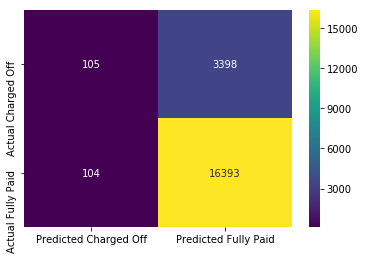

In [38]:
#get confusion matrix for model
plot_confusion_matrix(y_val, y_pred);

In [40]:
# get precision and recall for model
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

 Charged Off       0.50      0.03      0.06      3503
  Fully Paid       0.83      0.99      0.90     16497

    accuracy                           0.82     20000
   macro avg       0.67      0.51      0.48     20000
weighted avg       0.77      0.82      0.76     20000



In [41]:
# Get ROC AUC score for model
y_pred_proba = pipeline.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred_proba)

0.6757764121543497

## ROC AUC